In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

# Text preprocessing function
def preprocess_text(text):
    # Check if text is a string
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove emojis (if needed)
        text = text.encode('ascii', 'ignore').decode('ascii')
        # Tokenization and removal of stopwords
        stop_words = set(stopwords.words('english'))
        words = [word for word in text.split() if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(words)
    else:
        return ""  # Return empty string for non-string values

In [4]:
# Load the datasets

df_modi = pd.read_csv("../datasets/ModiRelatedTweetsWithSentiment.csv")
df_rahul = pd.read_csv("../datasets/RahulRelatedTweetsWithSentiment.csv")
df_modi = df_modi.drop(df_modi.columns[0], axis=1)
df_rahul = df_rahul.drop(df_rahul.columns[0], axis=1)

print(df_modi.head())
print(df_rahul.head())

                        Date             User  \
0  2019-05-18 23:50:47+00:00  advosushildixit   
1  2019-05-18 23:00:03+00:00           jiaeur   
2  2019-05-18 22:53:54+00:00    PVenkatGandhi   
3  2019-05-18 22:20:48+00:00      TheNirbhay1   
4  2019-05-18 21:22:29+00:00      ShakeChilli   

                                               Tweet Emotion  
0  @anjanaomkashyap I am seeing you as future #bj...     neg  
1  #LokSabhaElections2019 \n23rd May 2019 will re...     neg  
2  #LokSabhaElections2019 \n23rd May 2019 will re...     neg  
3  PM Modi creates a new record of being the only...     pos  
4  @abhijitmajumder Appointment of Successor! \n\...     pos  
                        Date             User  \
0  2019-05-18 19:49:52+00:00     Sunnysweet16   
1  2019-05-18 18:56:52+00:00    drnitinchaube   
2  2019-05-18 18:54:01+00:00        mrvivek07   
3  2019-05-18 18:52:03+00:00    JosephPravinP   
4  2019-05-18 18:31:10+00:00  VandanaMegastar   

                                

In [5]:
# Apply text preprocessing to each tweet

df_modi['Cleaned Tweet'] = df_modi['Tweet'].fillna('').apply(preprocess_text)
df_rahul['Cleaned Tweet'] = df_rahul['Tweet'].fillna('').apply(preprocess_text)

print(df_modi.head())
print(df_rahul.head())

                        Date             User  \
0  2019-05-18 23:50:47+00:00  advosushildixit   
1  2019-05-18 23:00:03+00:00           jiaeur   
2  2019-05-18 22:53:54+00:00    PVenkatGandhi   
3  2019-05-18 22:20:48+00:00      TheNirbhay1   
4  2019-05-18 21:22:29+00:00      ShakeChilli   

                                               Tweet Emotion  \
0  @anjanaomkashyap I am seeing you as future #bj...     neg   
1  #LokSabhaElections2019 \n23rd May 2019 will re...     neg   
2  #LokSabhaElections2019 \n23rd May 2019 will re...     neg   
3  PM Modi creates a new record of being the only...     pos   
4  @abhijitmajumder Appointment of Successor! \n\...     pos   

                                       Cleaned Tweet  
0  anjanaomkashyap seeing future bjp spokesperson...  
1  loksabhaelections2019 23rd may 2019 reveal eve...  
2  loksabhaelections2019 23rd may 2019 reveal eve...  
3  pm modi creates new record pm democratic count...  
4  abhijitmajumder appointment successor god 

In [6]:
# Encode sentiment labels (positive: 1, negative: 0)

df_modi['Encoded Emotion'] = df_modi['Emotion'].map({'pos': 1, 'neg': 0})
df_rahul['Encoded Emotion'] = df_rahul['Emotion'].map({'pos': 1, 'neg': 0})

print(df_modi.head())
print(df_rahul.head())

                        Date             User  \
0  2019-05-18 23:50:47+00:00  advosushildixit   
1  2019-05-18 23:00:03+00:00           jiaeur   
2  2019-05-18 22:53:54+00:00    PVenkatGandhi   
3  2019-05-18 22:20:48+00:00      TheNirbhay1   
4  2019-05-18 21:22:29+00:00      ShakeChilli   

                                               Tweet Emotion  \
0  @anjanaomkashyap I am seeing you as future #bj...     neg   
1  #LokSabhaElections2019 \n23rd May 2019 will re...     neg   
2  #LokSabhaElections2019 \n23rd May 2019 will re...     neg   
3  PM Modi creates a new record of being the only...     pos   
4  @abhijitmajumder Appointment of Successor! \n\...     pos   

                                       Cleaned Tweet  Encoded Emotion  
0  anjanaomkashyap seeing future bjp spokesperson...              0.0  
1  loksabhaelections2019 23rd may 2019 reveal eve...              0.0  
2  loksabhaelections2019 23rd may 2019 reveal eve...              0.0  
3  pm modi creates new record pm

In [7]:
# Add a column to indicate the source of the tweet

df_modi['Source'] = 'Modi'
df_rahul['Source'] = 'Rahul'
df_combined = pd.concat([df_modi, df_rahul], ignore_index=True)
df_combined.dropna(inplace=True)

print(df_combined.head())

                        Date             User  \
0  2019-05-18 23:50:47+00:00  advosushildixit   
1  2019-05-18 23:00:03+00:00           jiaeur   
2  2019-05-18 22:53:54+00:00    PVenkatGandhi   
3  2019-05-18 22:20:48+00:00      TheNirbhay1   
4  2019-05-18 21:22:29+00:00      ShakeChilli   

                                               Tweet Emotion  \
0  @anjanaomkashyap I am seeing you as future #bj...     neg   
1  #LokSabhaElections2019 \n23rd May 2019 will re...     neg   
2  #LokSabhaElections2019 \n23rd May 2019 will re...     neg   
3  PM Modi creates a new record of being the only...     pos   
4  @abhijitmajumder Appointment of Successor! \n\...     pos   

                                       Cleaned Tweet  Encoded Emotion Source  
0  anjanaomkashyap seeing future bjp spokesperson...              0.0   Modi  
1  loksabhaelections2019 23rd may 2019 reveal eve...              0.0   Modi  
2  loksabhaelections2019 23rd may 2019 reveal eve...              0.0   Modi  
3  p

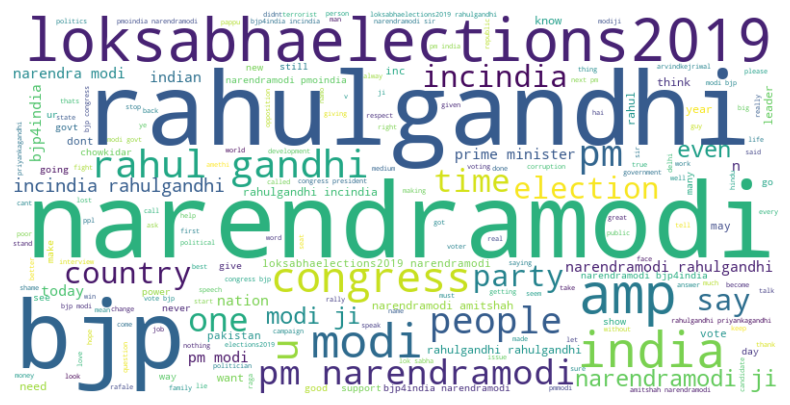

In [8]:
# Combine all cleaned tweets into a single string
text = ' '.join(df_combined['Cleaned Tweet'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(df_combined['Cleaned Tweet'], df_combined['Encoded Emotion'], test_size=0.2, random_state=42)

print(X_train.count())
print(y_train.count())
print(X_test.count())
print(y_test.count())

31953
31953
7989
7989


In [10]:
# Load the GloVe word embeddings

embeddings_index = {}
embedding_dim = 100

with open('../datasets/glove.twitter.27B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1193515 word vectors.


In [22]:
# Tokenize the text data

MAX_WORDS = 280
MAX_WORD_INDEX = 50000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=MAX_WORDS)
X_test = pad_sequences(X_test, maxlen=MAX_WORDS)

print(X_train.shape)
print(X_test.shape)

In [12]:
# Create an embedding matrix

embedding_matrix = np.zeros((MAX_WORD_INDEX, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < MAX_WORD_INDEX:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(50000, 100)


In [13]:
# Build an LSTM model

model = Sequential()
model.add(Embedding(input_dim=MAX_WORD_INDEX, output_dim=embedding_dim, weights=[embedding_matrix], input_length=MAX_WORDS, trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

c:\Users\debac\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,000,000 (19.07 MB)

 Trainable params: 5,000,000 (19.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
epochs = 5
batch_size = 128

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

Epoch 1/5
250/250 - 184s - 738ms/step - accuracy: 0.7021 - loss: 0.5660 - val_accuracy: 0.7435 - val_loss: 0.5184
Epoch 2/5
250/250 - 177s - 706ms/step - accuracy: 0.7765 - loss: 0.4754 - val_accuracy: 0.7739 - val_loss: 0.4766
Epoch 3/5
250/250 - 164s - 656ms/step - accuracy: 0.8147 - loss: 0.4055 - val_accuracy: 0.7784 - val_loss: 0.4662
Epoch 4/5
250/250 - 198s - 793ms/step - accuracy: 0.8483 - loss: 0.3471 - val_accuracy: 0.7811 - val_loss: 0.4930
Epoch 5/5
250/250 - 169s - 677ms/step - accuracy: 0.8801 - loss: 0.2821 - val_accuracy: 0.7794 - val_loss: 0.5011


In [15]:
# Checking the accuracy of the model
y_pred = model.predict(X_test, batch_size=batch_size, verbose=2)
y_pred = (y_pred > 0.5).astype(int)
y_pred = y_pred.flatten()
y_test = np.array(y_test)
print(classification_report(y_test, y_pred))

63/63 - 13s - 201ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82      4623
         1.0       0.77      0.67      0.72      3366

    accuracy                           0.78      7989
   macro avg       0.78      0.77      0.77      7989
weighted avg       0.78      0.78      0.78      7989



In [16]:
# Save the model to a file
model.summary()
model.save('../models/sentiment_model.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 280, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 280, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,505 (58.14 MB)

 Trainable params: 5,080,501 (19.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,161,004 (38.76 MB)

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [18]:
# Assuming y_true contains true labels (0 or 1) and y_score contains predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(np.array(y_test), y_pred)
roc_auc = auc(fpr, tpr)

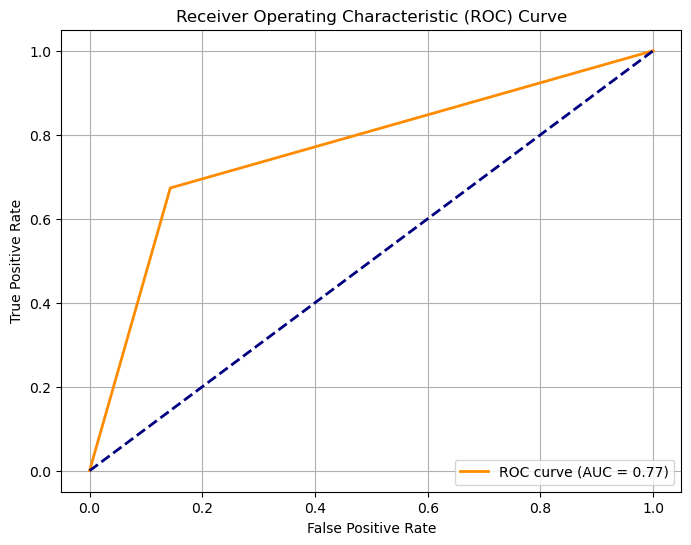

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [20]:
plt.savefig('roc_curve.png')

<Figure size 640x480 with 0 Axes>